# AstroPrism Tutorial: Instrument Response Model (Reprojection + PSF Convolution)

The instrument response transforms the latent sky signal into the noiseless model prediction:

$$\mu_i = P_i \ast R_i(s)$$

Where:
- $s$ = latent sky signal (from GP prior)
- $R_i$ = reprojection operator (maps sky to channel $i$'s pixel grid)
- $P_i$ = PSF convolution operator for channel $i$
- $\mu_i$ = noiseless model prediction for channel $i$

## Imports

In [2]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import warnings
from astropy.utils.exceptions import AstropyWarning
import jax

warnings.filterwarnings('ignore', category=AstropyWarning)

## Demonstration

### What is Reprojection?

**Reprojection** transforms an image from one World Coordinate System (WCS) to another. This is necessary because different observations may have different:
- Pixel scales
- Field rotations
- Pointing centers

In [9]:
# Load Dataset
from astroprism.io import load_multiple_datasets, MultiInstrumentDataset
paths_dict = {
    "JWST_MIRI": "../data/tutorial/jwst_miri", # path to dataset 1
    "JWST_NIRCAM": "../data/tutorial/jwst_nircam"  # path to dataset 2
}
dataset = load_multiple_datasets(paths_dict=paths_dict, extension="fits")
print(dataset.summary())

MultiInstrumentDataset Summary:
--------------------------------
Number of instruments: 2
Instrument keys: ['JWST_MIRI', 'JWST_NIRCAM']
Number of channels: 8
Channel keys: ['JWST_MIRI:jwst_miri_ngc1566_f1000w', 'JWST_MIRI:jwst_miri_ngc1566_f1130w', 'JWST_MIRI:jwst_miri_ngc1566_f2100w', 'JWST_MIRI:jwst_miri_ngc1566_f770w', 'JWST_NIRCAM:jwst_nircam_ngc1566_f200w', 'JWST_NIRCAM:jwst_nircam_ngc1566_f300m', 'JWST_NIRCAM:jwst_nircam_ngc1566_f335m', 'JWST_NIRCAM:jwst_nircam_ngc1566_f360m']
Channel shapes: [(2125, 1814), (2125, 1814), (2125, 1814), (2125, 1814), (8764, 5273), (4244, 2530), (4244, 2530), (4244, 2530)]
Pixel scales: [(0.11091449975820492, 0.1109144997630491), (0.11091449949791077, 0.11091449946799463), (0.11091449907273217, 0.11091449905375952), (0.11091450012231652, 0.11091450010349585), (0.030745888186397542, 0.030745888214638056), (0.06299856561171978, 0.06299856559416088), (0.06299972112784198, 0.06299972115150834), (0.06299972200415113, 0.06299972199117361)]



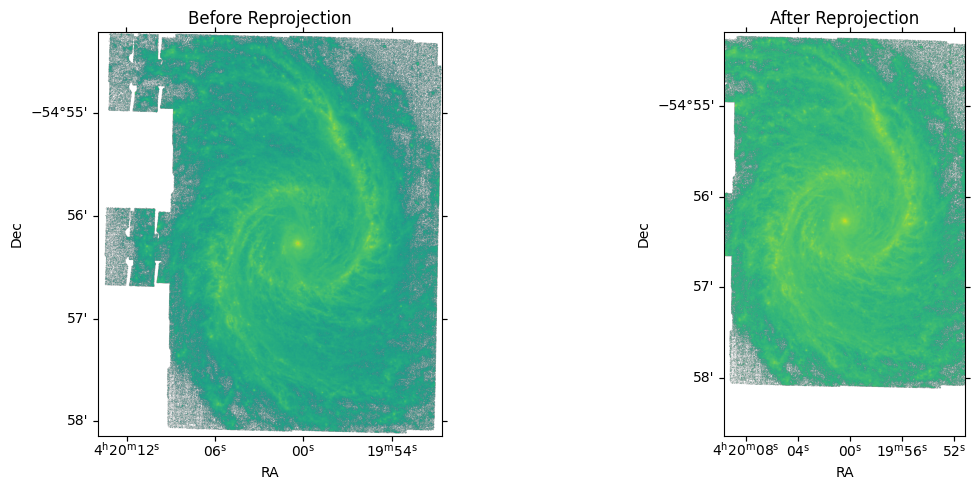

In [10]:
# Imports
from astroprism.operators import Reprojector, Convolver
from astropy.visualization.wcsaxes import WCSAxes

# Reprojector: Reprojects a signal from one WCS to another
reprojector = Reprojector(
    input_wcs=dataset.wcs[0],
    output_wcs=dataset.wcs[5],
    output_shape=dataset.shapes[5]
)

# Reproject a signal
reprojected_data = reprojector(dataset.data[0])

# Plot before and after with WCS projection
fig = plt.figure(figsize=(12, 5))

# Before (using original WCS)
ax1 = fig.add_subplot(1, 2, 1, projection=dataset.wcs[0])
ax1.imshow(dataset.data[0], origin='lower', norm=LogNorm())
ax1.set_title("Before Reprojection")
ax1.set_xlabel("RA")
ax1.set_ylabel("Dec")

# After (using target WCS)
ax2 = fig.add_subplot(1, 2, 2, projection=dataset.wcs[5])
ax2.imshow(reprojected_data, origin='lower', norm=LogNorm())
ax2.set_title("After Reprojection")
ax2.set_xlabel("RA")
ax2.set_ylabel("Dec")

plt.tight_layout()
plt.show()

### What is PSF Convolution?

The **Point Spread Function (PSF)** describes how a point source appears in the image. Convolution with the PSF blurs the sky model to match what the telescope sees.

AstroPFM supports learnable PSF parameters:
- `psf_sigma`: Additional Gaussian blur (models seeing/jitter)
- `psf_rotation`: PSF rotation angle (models field rotation)

In [ ]:
# Sample from GP
from astroprism.models import SpatialGP, MixtureGP
spatial_gp = SpatialGP(
    n_channels=len(dataset),          
    shape=dataset.shapes[0], # pick the first channel as reference for shape
    distances=dataset.pixel_scales[0] # pick the first channel as reference for pixel distances
)
mixture = MixtureGP(spatial_gps=spatial_gp)
key = jax.random.PRNGKey(0)
params = mixture.init(key)
sample = mixture(params)[2]

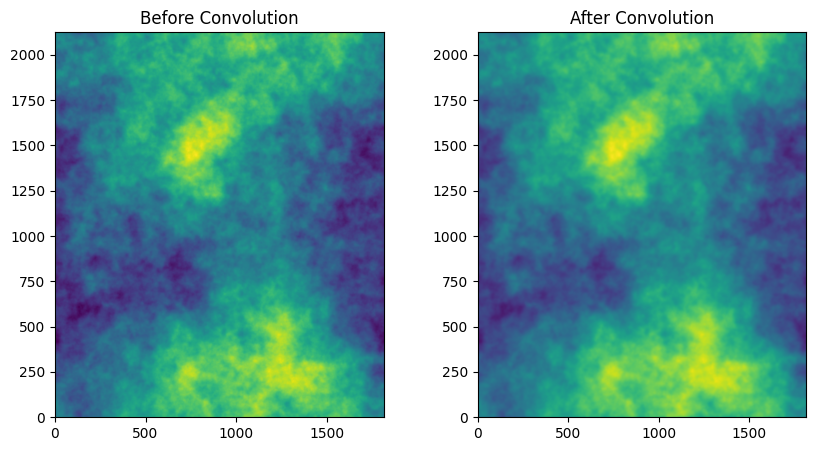

In [14]:
# Imports
from astroprism.operators import Convolver 

# Convolver: Convolves a signal with a PSF
convolver = Convolver(kernel=dataset.psfs[2])

# Convolve a signal drawn from the MixtureGP prior

convolved_data = convolver(sample)

# Plot before and after
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(sample, origin='lower', norm=LogNorm())
axes[0].set_title("Before Convolution")
axes[1].imshow(convolved_data, origin='lower', norm=LogNorm())
axes[1].set_title("After Convolution")
plt.show()

### Instrument Response Model

The `InstrumentResponse` class combines reprojection and convolution into a single operator. It manages:
- One `Reprojector` per channel
- One `Convolver` per channel  
- Learnable PSF parameters (blur, rotation)

In [15]:
# Imports 
from astroprism.models.response import InstrumentResponse

# Pick a WCS as reference (here the first channel)
wcs_ref = dataset.wcs[0]

# InstrumentResponse: Combines Reprojection and PSF Convolution
response = InstrumentResponse(
    dataset=dataset,
    signal_wcs=wcs_ref,
    signal_shape=dataset.shapes[0], # pick the first channel as reference for shape
    psf_rotation=(45, 1.0),
)

# Print the domain of the InstrumentResponse
print("InstrumentResponse domain keys:", list(response.domain.keys()))

InstrumentResponse domain keys: ['psf_sigma', 'psf_rotation']
